1. trying to play around w/ the relatively cleaned data
-some ideas:
a) separate based on type of tumor
*will be easier to meet completeness criteria if n is smaller
b) figure out which non-imaging features I want to include in algorithm
*recommned 10+ for the algorithms
**do they have to be the same features for each tumor type? might be more difficult if so
c) figure out how to visualize/manipulate/interpret imaging features 
d) figure out which non-imaging features would be interesting
*outcome data
*predicting mutation statuses
*predicting histologic grade w/ image features and demographic data

In [1]:
#completeness of non-image features

import pandas as pd
import os

# Paths to each cleaned master CSV
datasets = {
    "convnext": "/Users/joi263/Documents/MultimodalTabData/data/convnext_data/convnext_cleaned_master.csv",
    "efficientnet": "/Users/joi263/Documents/MultimodalTabData/data/efficientnet_data/efficientnet_cleaned_master.csv",
    "imagenet_resnet50": "/Users/joi263/Documents/MultimodalTabData/data/imagenet_resnet50_data/imagenet_resnet50_cleaned_master.csv",
    "pretrained_resnet50": "/Users/joi263/Documents/MultimodalTabData/data/pretrained_resnet50_data/pretrained_resnet50_cleaned_master.csv",
    "vit_base": "/Users/joi263/Documents/MultimodalTabData/data/vit_base_data/vit_base_cleaned_master.csv"
}

for name, path in datasets.items():
    # Load dataset
    df = pd.read_csv(path)
    
    # Identify non‐image columns
    non_image_cols = [c for c in df.columns if not c.startswith("feature_")]
    
    # Compute completeness
    completeness = pd.DataFrame({
        "column": non_image_cols,
        "non_missing": [df[c].notna().sum() for c in non_image_cols],
        "percent_complete": [round(df[c].notna().mean() * 100, 2) for c in non_image_cols]
    })
    
    # Save to the dataset’s folder
    save_dir = os.path.dirname(path)
    out_path = os.path.join(save_dir, f"{name}_non_image_completeness.csv")
    completeness.to_csv(out_path, index=False)
    print(f"✅ Saved non-image completeness for {name}: {out_path}")


✅ Saved non-image completeness for convnext: /Users/joi263/Documents/MultimodalTabData/data/convnext_data/convnext_non_image_completeness.csv
✅ Saved non-image completeness for efficientnet: /Users/joi263/Documents/MultimodalTabData/data/efficientnet_data/efficientnet_non_image_completeness.csv
✅ Saved non-image completeness for imagenet_resnet50: /Users/joi263/Documents/MultimodalTabData/data/imagenet_resnet50_data/imagenet_resnet50_non_image_completeness.csv
✅ Saved non-image completeness for pretrained_resnet50: /Users/joi263/Documents/MultimodalTabData/data/pretrained_resnet50_data/pretrained_resnet50_non_image_completeness.csv
✅ Saved non-image completeness for vit_base: /Users/joi263/Documents/MultimodalTabData/data/vit_base_data/vit_base_non_image_completeness.csv


looking at imaging features before algorithms

1) distribution and missingness checks
-histograms or density plot for randomly selected features to make sure non are always zero or extremely skewed
-pairwise correlations among features to ID strongly collinear subsets you might collapse

2) dimensionality reduction for visualization
-PCA: project 28-d vectors down to 2–3 principal components, then color-code by permanent diagnosis or by mortality outcome—see if classes separate visually
-t-SNE / UMAP: a non-linear embedding that can reveal clusters of cases with similar imaging signatures

3) unsupervised clustering
-run K means or hierarchical clustering on embeddings to see if you recover meaningful subgroups (ie. GBM subtypes) w/o supervision

4) feature selection and importance
-univariate tests: test each feature’s distribution across alive vs. dead to pre-filter the top 20–50
-tree-based importance: train a quick XGBoost on imaging alone and pull the top 20 features by gain
-regularized methods: LASSO or ElasticNet can shrink irrelevant embeddings to zero

5) post-hoc interpretability
-once you train your final models, use SHAP or Integrated Gradients (for TabNet/TabM) to rank which embeddings most drive the mortality prediction
-map the top embeddings back to image patches (if you saved the spatial indices) to see what patterns in the histology or radiology they correspond to

Summary:
1) Quality-check your embeddings (no dead-flat columns)
2) Visualize their structure relative to known labels
3) Select the most predictive ones before full model training
4) Interpret what the top predictors are actually looking at in the images

In [11]:
import numpy as np

df = pd.read_csv("/Users/joi263/Documents/MultimodalTabData/data/convnext_data/convnext_cleaned_master.csv")
# Create 1-year mortality: died within 12 months
df["mortality_1yr"] = np.where(
    (df["survival"] <= 12) & (df["patient_status"] == 2.0), 1, 0
)
# Create 2-year mortality similarly
df["mortality_2yr"] = np.where(
    (df["survival"] <= 24) & (df["patient_status"] == 2.0), 1, 0
)


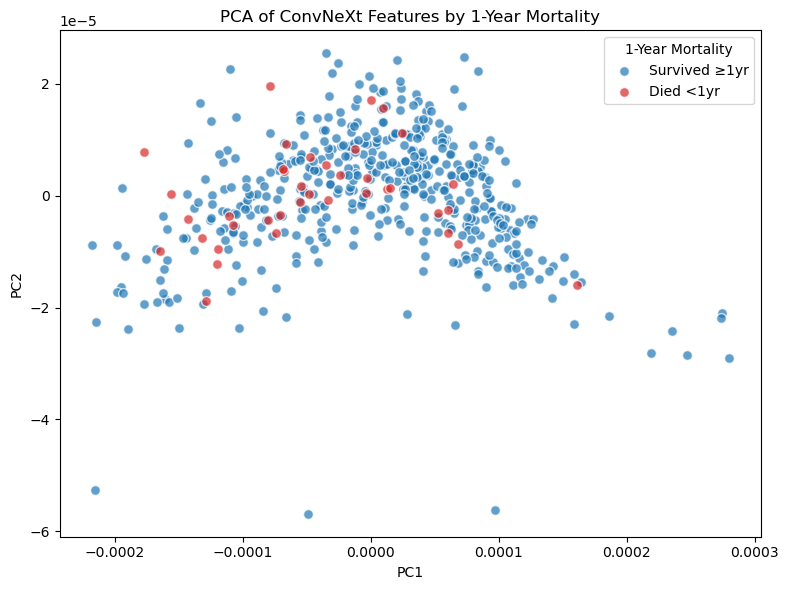

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

feature_cols = [c for c in df.columns if c.startswith("feature_")]
X = df[feature_cols]
y = df["mortality_1yr"]

coords = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(8,6))
for val, lbl, clr in [(0, "Survived ≥1yr", "tab:blue"), (1, "Died <1yr", "tab:red")]:
    mask = (y == val)
    plt.scatter(coords[mask,0], coords[mask,1], c=clr, label=lbl, alpha=0.7, edgecolors="w", s=50)
plt.legend(title="1-Year Mortality")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of ConvNeXt Features by 1-Year Mortality")
plt.tight_layout()
plt.show()


Interpretation of plot

Imaging features alone (ConvNeXt embeddings) don’t cleanly separate 1-year mortality in a simple linear 2-component view.

That doesn’t mean the embeddings are useless—they may separate better in higher dimensions or only when combined with clinical/molecular features.

No obvious cluster of “high-risk” patients; you’ll need more powerful classifiers (XGBoost, TabNet, etc.) that can carve out non-linear decision boundaries in 128-D space.

No glaring, low-dimensional separation—you’ll need full 128-D models.

Need for non-linear classifiers and / or multimodal inputs (clinical + molecular + imaging) to predict mortality effectively.